In [1]:
import tensorflow as tf
#if not tf.executing_eagerly():
tf.enable_eager_execution()
from vacuum.datasets import  generative_model
from vacuum.io_ import preprocess, deprocess
from vacuum.util import shift
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_batch = generative_model(psf_glob="/scratch/datasets/meerkat16_deep2like_morerange/*-bigpsf-psf.fits")

In [89]:
iterator = train_batch.make_one_shot_iterator()
index, min_flux, max_flux, psf, dirty, skymodel = iterator.get_next()

In [90]:
scaled_skymodel = preprocess(skymodel, min_flux, max_flux)
scaled_dirty = preprocess(dirty, min_flux, max_flux)

In [91]:
deprocessed_output = deprocess(scaled_skymodel, min_flux, max_flux)
shifted = shift(psf, x=-1)
filter_ = tf.expand_dims(tf.expand_dims(tf.squeeze(shifted), 2), 3)
convolved = tf.nn.conv2d(deprocessed_output, filter_, [1, 1, 1, 1], "SAME")
scaled = (convolved/tf.reduce_max(convolved)) * tf.reduce_max(dirty)
scaled_residuals = dirty - scaled
residuals = dirty - convolved

In [92]:
print(tf.reduce_max(convolved)/tf.reduce_max(dirty))

tf.Tensor(1.0676137, shape=(), dtype=float32)


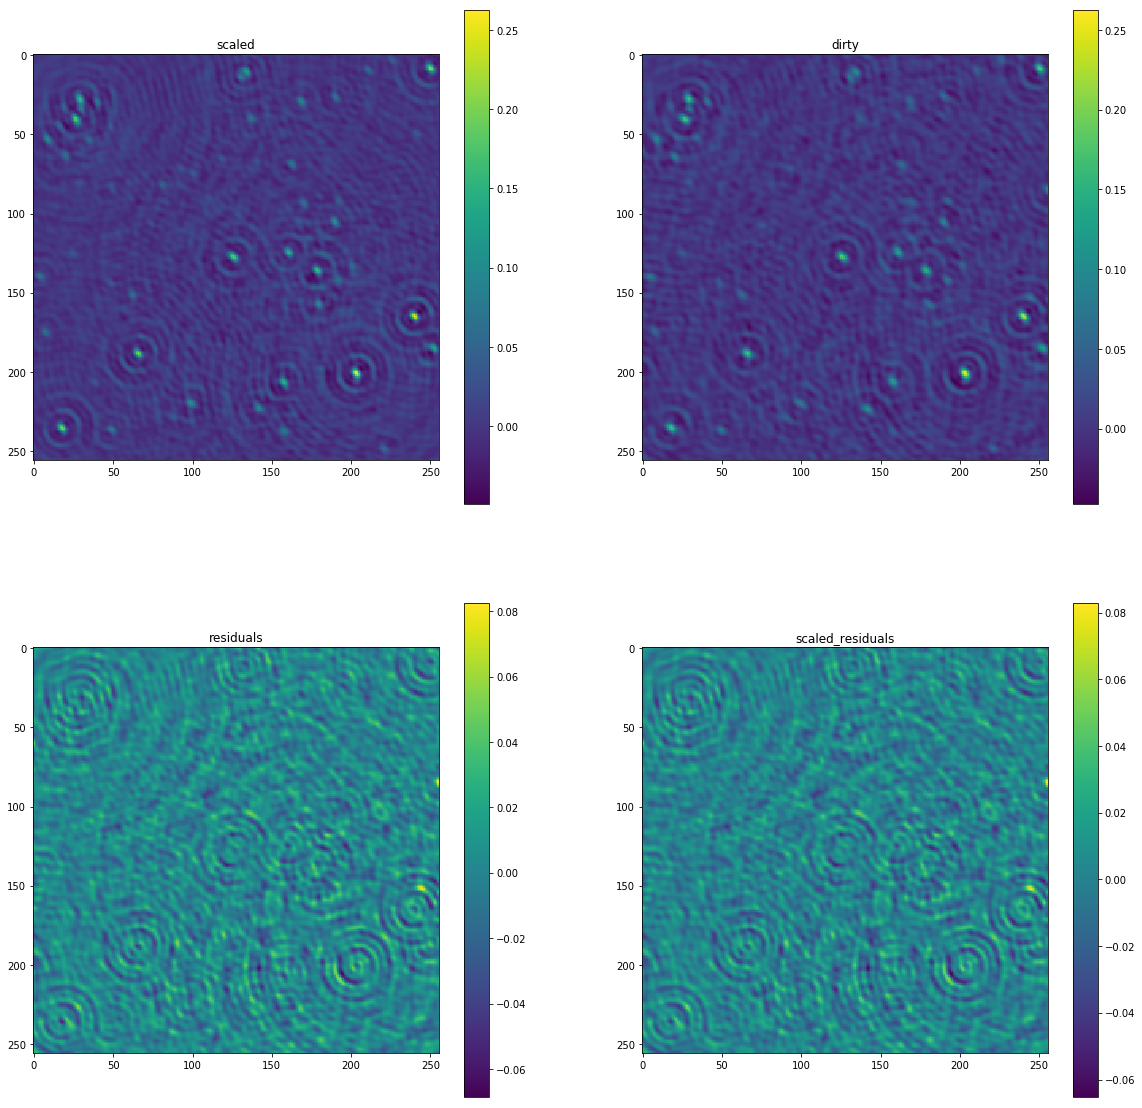

In [93]:
def render(f, a, imgdata, title):
    i = a.imshow(imgdata)
    f.colorbar(i, ax=a)
    a.set_title(title)
fig, ((a1, a2), (a3, a4)) = plt.subplots(2, 2, figsize=(20, 20))
render(fig, a1, tf.squeeze(scaled), 'scaled')
render(fig, a2, tf.squeeze(dirty), 'dirty')
render(fig, a3, tf.squeeze(residuals), 'residuals')
render(fig, a4, tf.squeeze(scaled_residuals), 'scaled_residuals')